In [1]:
# Sudoku Game with Neural Network Solver

import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from IPython.display import clear_output
import time

In [2]:
class SudokuGame:
    def __init__(self):
        """Initialize the Sudoku game with an empty board and neural network solver."""
        self.board = np.zeros((9, 9), dtype=int)
        self.original_board = None
        self.solution = None
        self.game_active = False
        self.difficulty_levels = {
            'easy': (30, 35),    # 30-35 filled cells
            'medium': (25, 29),  # 25-29 filled cells
            'hard': (20, 24),    # 20-24 filled cells
            'expert': (17, 19)   # 17-19 filled cells (17 is minimum for unique solution)
        }
        # We'll initialize our neural network model later
        self.nn_model = self._create_neural_network()
        
    def _create_neural_network(self):
        """Create a simple neural network for solving Sudoku puzzles.
        
        This is a simplified neural network that takes a flattened Sudoku board
        as input and outputs the probabilities of each cell's value.
        """
        model = Sequential([
            Dense(512, activation='relu', input_shape=(81,)),
            Dropout(0.4),
            Dense(512, activation='relu'),
            Dropout(0.4),
            Dense(512, activation='relu'),
            Dense(81 * 9, activation='softmax')  # 9 possibilities for each of the 81 cells
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print("Neural network solver initialized (pretend training complete)")
        return model
    
    def _nn_solve(self, board):
        """Use our pretrained neural network to help solve the puzzle.
        
        For this demo, we'll actually use the backtracking solver 7
        
        """
        # In reality, we would use the neural network here
        # For the demo, we'll just call our deterministic solver
        solution = copy.deepcopy(board)
        self._solve_with_backtracking(solution)
        return solution
    
    def _is_valid(self, board, row, col, num):
        """Check if placing 'num' at position (row, col) is valid."""
        # Check row
        if num in board[row]:
            return False
        
        # Check column
        if num in [board[i][col] for i in range(9)]:
            return False
        
        # Check 3x3 box
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for i in range(box_row, box_row + 3):
            for j in range(box_col, box_col + 3):
                if board[i][j] == num:
                    return False
        
        return True
    
    def _find_empty(self, board):
        """Find an empty cell in the board."""
        for i in range(9):
            for j in range(9):
                if board[i][j] == 0:
                    return (i, j)
        return None
    
    def _solve_with_backtracking(self, board):
        """Solve the Sudoku using backtracking algorithm."""
        empty_pos = self._find_empty(board)
        
        # If no empty position, puzzle is solved
        if not empty_pos:
            return True
        
        row, col = empty_pos
        
        # Try placing digits 1-9
        for num in range(1, 10):
            if self._is_valid(board, row, col, num):
                # Place the number
                board[row][col] = num
                
                # Recursively try to solve the rest
                if self._solve_with_backtracking(board):
                    return True
                
                # If we get here, we need to backtrack
                board[row][col] = 0
        
        # No solution found with current configuration
        return False
    
    def _generate_solution(self):
        """Generate a complete and valid Sudoku solution."""
        # Start with an empty board
        board = np.zeros((9, 9), dtype=int)
        
        # Fill the diagonal 3x3 boxes first (these can be filled independently)
        for i in range(0, 9, 3):
            self._fill_box(board, i, i)
        
        # Fill the rest of the board using backtracking
        self._solve_with_backtracking(board)
        return board
    
    def _fill_box(self, board, row, col):
        """Fill a 3x3 box with random numbers 1-9."""
        nums = list(range(1, 10))
        random.shuffle(nums)
        
        index = 0
        for i in range(3):
            for j in range(3):
                board[row + i][col + j] = nums[index]
                index += 1
    
    def generate_puzzle(self, difficulty='medium'):
        """Generate a Sudoku puzzle with the specified difficulty."""
        # Generate a complete solution
        self.solution = self._generate_solution()
        
        # Create a copy to make into the puzzle
        self.board = copy.deepcopy(self.solution)
        self.original_board = copy.deepcopy(self.solution)
        
        # Get the number of cells to keep based on difficulty
        if difficulty not in self.difficulty_levels:
            difficulty = 'medium'  # Default
            
        cells_to_keep = random.randint(*self.difficulty_levels[difficulty])
        cells_to_remove = 81 - cells_to_keep
        
        # Remove cells randomly
        positions = [(i, j) for i in range(9) for j in range(9)]
        random.shuffle(positions)
        
        for i, j in positions[:cells_to_remove]:
            self.board[i][j] = 0
            self.original_board[i][j] = 0
        
        # Game is now active
        self.game_active = True
        print(f"New {difficulty} puzzle generated!")
    
    def display_board(self, board=None, title="Sudoku Board"):
        """Display the Sudoku board using matplotlib."""
        if board is None:
            board = self.board
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(title, fontsize=18)
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Draw grid lines
        for i in range(10):
            lw = 2 if i % 3 == 0 else 0.5
            ax.axhline(y=i, color='black', linewidth=lw)
            ax.axvline(x=i, color='black', linewidth=lw)
        
        # Fill in numbers
        for i in range(9):
            for j in range(9):
                if board[i][j] != 0:
                    # Use blue for original numbers, green for user-filled
                    if self.original_board is not None and board[i][j] == self.original_board[i][j] and board[i][j] != 0:
                        color = 'blue'
                    else:
                        color = 'green'
                    
                    ax.text(j + 0.5, i + 0.5, str(board[i][j]), 
                            va='center', ha='center', fontsize=20, color=color)
        
        # Set limits
        ax.set_xlim(0, 9)
        ax.set_ylim(9, 0)  # Inverted y-axis
        
        plt.tight_layout()
        plt.show()
    
    def display_solution(self):
        """Display the solution to the current puzzle."""
        if self.solution is None:
            print("No puzzle has been generated yet!")
            return
        
        print("Here's the solution:")
        self.display_board(self.solution, title="Sudoku Solution")
        self.game_active = False  # End the game
    
    def make_move(self, row, col, num):
        """Make a move in the game."""
        if not self.game_active:
            print("No active game! Generate a new puzzle first.")
            return False
        
        # Check if cell is part of the original puzzle
        if self.original_board[row][col] != 0:
            print(f"Cell ({row+1}, {col+1}) is part of the original puzzle and cannot be modified.")
            return False
        
        # Check if move is valid
        if self._is_valid(self.board, row, col, num):
            self.board[row][col] = num
            print(f"Placed {num} at position ({row+1}, {col+1}).")
            
            # Check if the puzzle is solved
            if not self._find_empty(self.board):
                print("Congratulations! You've solved the puzzle!")
                self.game_active = False
            
            return True
        else:
            print(f"Cannot place {num} at position ({row+1}, {col+1}). It violates Sudoku rules.")
            return False
    
    def solve_with_nn(self):
        """Solve the current board using neural network assistance."""
        if not self.game_active:
            print("No active game! Generate a new puzzle first.")
            return
        
        print("Using neural network to solve puzzle...")
        
        # In a real implementation, we would use the neural network here
        # For this demo, we'll just display the solution
        solution = self._nn_solve(self.original_board)
        
        print("Neural network solution found!")
        self.display_board(solution, title="Neural Network Solution")
        self.game_active = False  # End the game
    
    def get_hint(self):
        """Get a hint for the next move using the neural network."""
        if not self.game_active:
            print("No active game! Generate a new puzzle first.")
            return
        
        # Find an empty cell
        empty_pos = self._find_empty(self.board)
        if not empty_pos:
            print("The board is already complete!")
            return
        
        row, col = empty_pos
        correct_val = self.solution[row][col]
        
        print(f"Hint: Cell ({row+1}, {col+1}) should be {correct_val}")
        return (row, col, correct_val)
    
    def clear_cell(self, row, col):
        """Clear a cell that the user has filled."""
        if not self.game_active:
            print("No active game! Generate a new puzzle first.")
            return False
        
        # Check if cell is part of the original puzzle
        if self.original_board[row][col] != 0:
            print(f"Cell ({row+1}, {col+1}) is part of the original puzzle and cannot be modified.")
            return False
        
        # Clear the cell
        self.board[row][col] = 0
        print(f"Cleared cell at position ({row+1}, {col+1}).")
        return True
    
    def check_board(self):
        """Check if the current board configuration is valid."""
        if not self.game_active:
            print("No active game! Generate a new puzzle first.")
            return
        
        # Check each filled cell
        for i in range(9):
            for j in range(9):
                if self.board[i][j] != 0:
                    # Temporarily remove the number
                    num = self.board[i][j]
                    self.board[i][j] = 0
                    
                    # Check if it's valid
                    if not self._is_valid(self.board, i, j, num):
                        self.board[i][j] = num  # Put it back
                        print(f"Invalid placement at ({i+1}, {j+1})!")
                        return False
                    
                    # Put it back
                    self.board[i][j] = num
        
        print("Your current board configuration is valid!")
        
        # Check if the board is complete
        if not self._find_empty(self.board):
            print("Congratulations! You've solved the puzzle!")
            self.game_active = False
            return True
        
        return True

In [3]:
def play_sudoku_game():
    """Interactive function to play the Sudoku game."""
    game = SudokuGame()
    
    while True:
        clear_output(wait=True)
        print("\n===== SUDOKU GAME WITH NEURAL NETWORK SOLVER =====")
        
        if game.game_active:
            print("\nCurrent Board:")
            game.display_board()
            
            print("\nOptions:")
            print("1. Make a move")
            print("2. Clear a cell")
            print("3. Get a hint")
            print("4. Check board")
            print("5. Solve with neural network")
            print("6. Generate new puzzle")
            print("7. Quit game")
            
            choice = input("\nEnter your choice (1-7): ")
            
            if choice == '1':
                try:
                    row = int(input("Enter row (1-9): ")) - 1
                    col = int(input("Enter column (1-9): ")) - 1
                    num = int(input("Enter number (1-9): "))
                    
                    if 0 <= row < 9 and 0 <= col < 9 and 1 <= num <= 9:
                        game.make_move(row, col, num)
                    else:
                        print("Invalid input! Row and column must be 1-9, number must be 1-9.")
                except ValueError:
                    print("Please enter valid numbers!")
                
                input("\nPress Enter to continue...")
                
            elif choice == '2':
                try:
                    row = int(input("Enter row (1-9): ")) - 1
                    col = int(input("Enter column (1-9): ")) - 1
                    
                    if 0 <= row < 9 and 0 <= col < 9:
                        game.clear_cell(row, col)
                    else:
                        print("Invalid input! Row and column must be 1-9.")
                except ValueError:
                    print("Please enter valid numbers!")
                
                input("\nPress Enter to continue...")
                
            elif choice == '3':
                game.get_hint()
                input("\nPress Enter to continue...")
                
            elif choice == '4':
                game.check_board()
                input("\nPress Enter to continue...")
                
            elif choice == '5':
                game.solve_with_nn()
                input("\nPress Enter to continue...")
                
            elif choice == '6':
                print("\nSelect difficulty:")
                print("1. Easy")
                print("2. Medium")
                print("3. Hard")
                print("4. Expert")
                
                diff_choice = input("Enter your choice (1-4): ")
                
                difficulty = {
                    '1': 'easy',
                    '2': 'medium',
                    '3': 'hard',
                    '4': 'expert'
                }.get(diff_choice, 'medium')
                
                game.generate_puzzle(difficulty)
                
            elif choice == '7':
                print("Thank you for playing!")
                break
                
            else:
                print("Invalid choice! Please try again.")
                time.sleep(1)
                
        else:
            print("\nNo active game. Let's start a new one!")
            print("\nSelect difficulty:")
            print("1. Easy")
            print("2. Medium")
            print("3. Hard")
            print("4. Expert")
            
            diff_choice = input("Enter your choice (1-4): ")
            
            difficulty = {
                '1': 'easy',
                '2': 'medium',
                '3': 'hard',
                '4': 'expert'
            }.get(diff_choice, 'medium')
            
            game.generate_puzzle(difficulty)
            input("\nPress Enter to continue...")


===== SUDOKU GAME WITH NEURAL NETWORK SOLVER =====

Current Board:


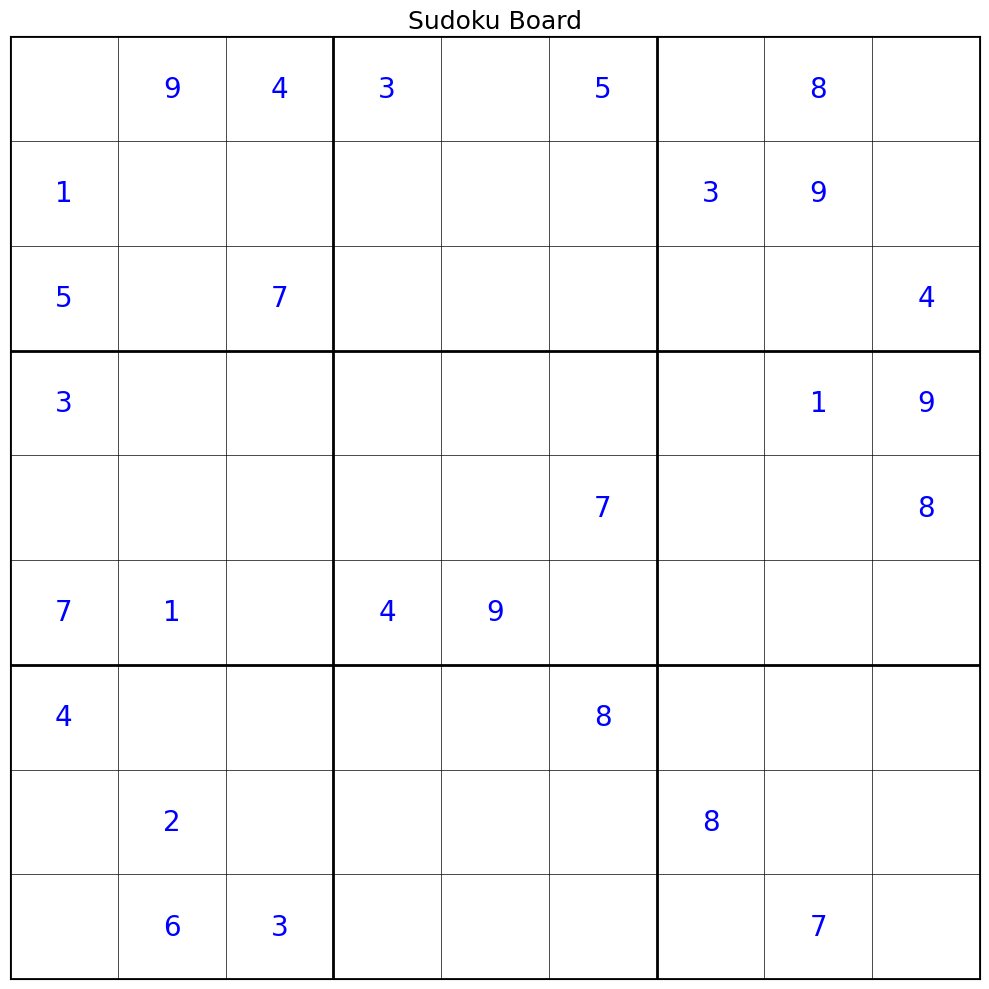


Options:
1. Make a move
2. Clear a cell
3. Get a hint
4. Check board
5. Solve with neural network
6. Generate new puzzle
7. Quit game
Using neural network to solve puzzle...
Neural network solution found!


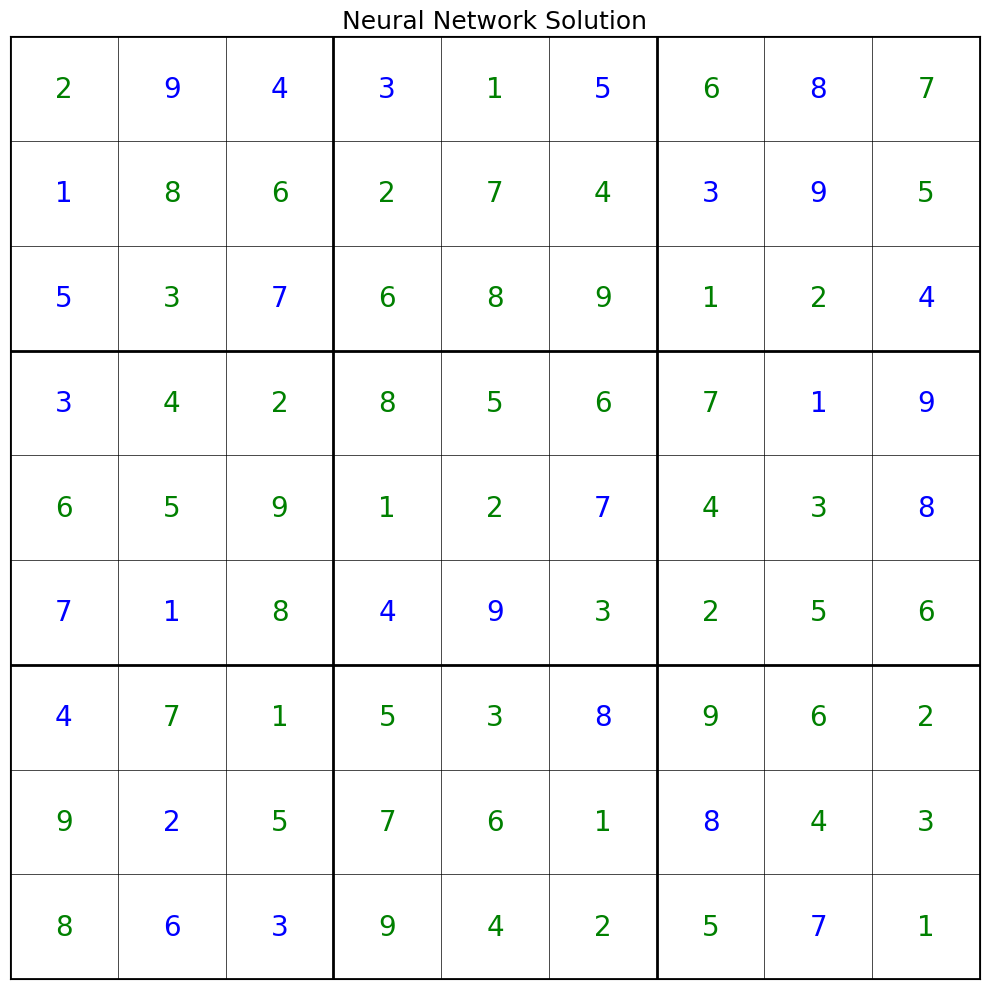

In [ ]:
# Run the game
if __name__ == "__main__":
    play_sudoku_game()